# RL

**Выполнять задание следует с текущими значениями гиперпараметров. Для проверки ниже будут приведены ответы, которые должны получиться в результате выполнения задания.**

После того, как заявленные значения совпадут и будут получены работающие модели выполните следующие задания:

1. **Базовая часть (3 балла):** исследуйте влияние параметров `gamma, lr_rate, epsilon` на обучение моделей. Постройте графики.
2. **Опциональная часть (+2 балла):** Реализуйте остальные стратегии выбора действий (softmax, UCB, оптимистичные начальные оценки), описанные в лекции. Визуализируйте результаты.

Зададим гиперпараметры модели

In [279]:
from fontTools.misc.bezierTools import epsilon

random_seed = 100 #Random seed
time_delay = 1 # Задержка времени при отрисовке процесса игры после обучения (секунды)


Импортируем библиотеки, создаем свою среду размера 6х6. S обозначает точку старта. F -- лед безопасен, H -- проталина, G -- цель. Параметр `is_slippery=False` отвечает за условное отсутствие скольжения. То есть если агент выбрал действие пойти направо, то он переместится в соответствующее состояние. В общем случае из-за "скольжения" можно оказаться в другом состоянии. Мы также скопировали из библиотки GYM и слегка модифицировали функцию ```generate_random_map ```, для того, чтобы генерировать произвольные карты на основе ```random_seed ```.





In [6]:
# Установим нужную версию библиотеки gym
!git clone https://github.com/dvolchek/gym_0_18_0.git -q
%cd gym_0_18_0
!pip install -e. -q

fatal: destination path 'gym_0_18_0' already exists and is not an empty directory.
/Users/gosh_rivgosh/DataspellProjects/DL_ITMO/gym_0_18_0


In [280]:
import gym
import numpy as np
import time
from IPython.display import clear_output


def generate_random_map(size, p, sd):
    """Generates a random valid map (one that has a path from start to goal)
    :param size: size of each side of the grid
    :param p: probability that a tile is frozen
    """
    valid = False
    np.random.seed(sd)

    # DFS to check that it's a valid path.
    def is_valid(res):
        frontier, discovered = [], set()
        frontier.append((0,0))
        while frontier:
            r, c = frontier.pop()
            if not (r,c) in discovered:
                discovered.add((r,c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= size or c_new < 0 or c_new >= size:
                        continue
                    if res[r_new][c_new] == 'G':
                        return True
                    if (res[r_new][c_new] not in '#H'):
                        frontier.append((r_new, c_new))
        return False

    while not valid:
        p = min(1, p)
        res = np.random.choice(['F', 'H'], (size, size), p=[p, 1-p])
        res[0][0] = 'S'
        res[-1][-1] = 'G'
        valid = is_valid(res)
    return ["".join(x) for x in res]

#Генерация карты
random_map = generate_random_map(size=6, p=0.8, sd = random_seed) #Создаем свою карту
env = gym.make("FrozenLake-v0", desc=random_map, is_slippery=False) #Инициализируем среду
print("Ваша карта")
env.render() #Выводим карту на экран

Ваша карта

SFFHFF
FHFFHF
FFFHHF
HFFHHF
FFFFFF
FFFFFG


Функции выбора действия и обновления таблицы ценности действий. Строчка *** используется для того, чтобы проверять ответы в openedx. Вне рамках академической задачи лучше использовать оригинальный метод класса `environment`, то есть:

`action = env.action_space.sample()`

# Задача 1
Дополните функцию ```learn()```, чтобы в результате ее вызова обновлялось значение ценности текущего действия согласно алгоритму Q-обучения



In [319]:
def choose_action(state, epsilon, Q):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0,env.action_space.n) #***
    else:
        action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action

def learn(lr_rate, gamma, state, state2, reward, action, done, Q):
    if done:
        Q[state, action] = Q[state, action] + lr_rate*(reward - Q[state, action])
    else:
        Q[state, action] = Q[state, action] + lr_rate*(reward+ gamma*np.max(Q[state2, :]) - Q[state, action])

# Задача 2
Дополните следующий код так, чтобы в результате обучения модели можно было узнать количество побед и номер игры (`game`), на котором агент впервые одержал пятую победу подряд.

Поясним, что возвращает функция ```env.step(action)```

```state2``` -- следующее состояние

```reward``` -- награда

```done``` -- флаг окончания игры. True в случае победы или падения в проталину. False в остальных случаях.




In [352]:
from tqdm import tqdm

# Inititalization
np.random.seed(random_seed)


def play_game(total_games=10000, max_steps=100, epsilon=0.1, gamma=0.8, lr_rate=0.9):
    '''
    :param total_games: Количество игр
    :param max_steps: Максимальное количество шагов в игре
    :param epsilon: Параметр эпсилон при использовании эпсилон жадной стратегии
    :param gamma: Коэффициент дисконтирования гамма
    :param lr_rate: Коэффициент скорости обучения альфа
    :return: Количество выигранных игр, Пять побед подряд впервые было одержано в игре 
    '''

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    win_count = 0
    five_win_array = []
    game_with_five_win = 0
    five_flag = False
    reward_array = []
    for game in tqdm(range(total_games)):
        state = env.reset()
        t = 0
        while t < max_steps:

            t += 1

            action = choose_action(state, epsilon, Q)
            state2, reward, done, info = env.step(action)

            if t == max_steps:
                done = True
            if reward == 1:
                win_count += 1
                five_win_array.append(1)
                if sum(five_win_array) == 5 and len(five_win_array) == 5 and five_flag is False:
                    game_with_five_win = game + 1
                    five_flag = True
            elif reward == 0 and done:
                five_win_array = []

            learn(lr_rate, gamma, state, state2, reward, action, done, Q)
            state = state2

            if done:
                reward_array.append(reward)
                break
    return win_count, game_with_five_win, np.cumsum(reward_array)/(np.arange(total_games)+1)

Вывод ответов при заданных параметрах

In [329]:
win_count, game_with_five_win = play_game()
print("Количество побед в серии из 10 000 игр: ", win_count)
print("Пять побед подряд впервые было одержано в игре ", game_with_five_win)


100%|██████████| 10000/10000 [00:01<00:00, 7486.86it/s]

Количество побед в серии из 10 000 игр:  7914
Пять побед подряд впервые было одержано в игре  885


Должны получиться следующие результаты.


*  Количество побед в серии из 10 000 игр:  7914
*  Пять побед подряд впервые было одержано в игре  885




Оценим влияние параметров на обучение модели и построим графики

100%|██████████| 10000/10000 [00:01<00:00, 7794.05it/s]


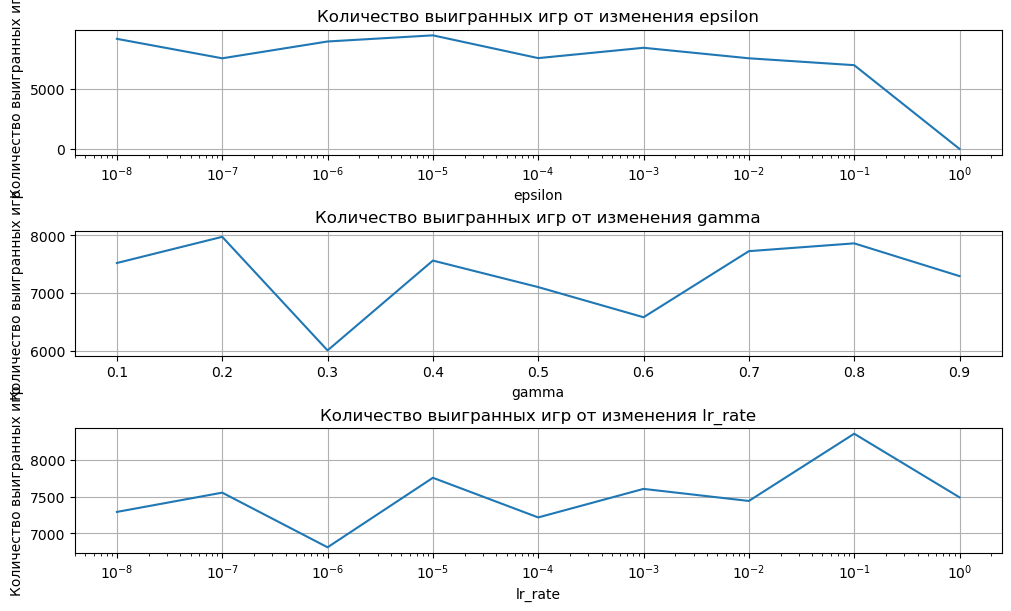

In [338]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(10, 6), constrained_layout=True)

eps_array = [10**i for i in range(-8,1)]
win_eps_array = [play_game(epsilon = eps)[0] for eps in eps_array]

gamma_array = [0.1*i for i in range(1,10)]
win_gamma_array = [play_game(gamma = gm)[0] for gm in gamma_array]


lr_rate_array = [10**i for i in range(-8,1)]
win_lr_rate_array = [play_game(lr_rate = lr)[0] for lr in lr_rate_array]


axs[0].set_title('Количество выигранных игр от изменения epsilon')
axs[0].set_xlabel('epsilon')
axs[0].set_ylabel('Количество выигранных игр')
axs[0].plot(eps_array, win_eps_array)
axs[0].set_xscale('log')
axs[0].grid(True)

axs[1].set_title('Количество выигранных игр от изменения gamma')
axs[1].set_xlabel('gamma')
axs[1].set_ylabel('Количество выигранных игр')
axs[1].plot(gamma_array, win_gamma_array)
axs[1].grid(True)

axs[2].set_title('Количество выигранных игр от изменения lr_rate')
axs[2].set_xlabel('lr_rate')
axs[2].set_ylabel('Количество выигранных игр')
axs[2].set_xscale('log')
axs[2].plot(lr_rate_array, win_lr_rate_array)
axs[2].grid(True)


100%|██████████| 10000/10000 [00:01<00:00, 8566.63it/s]


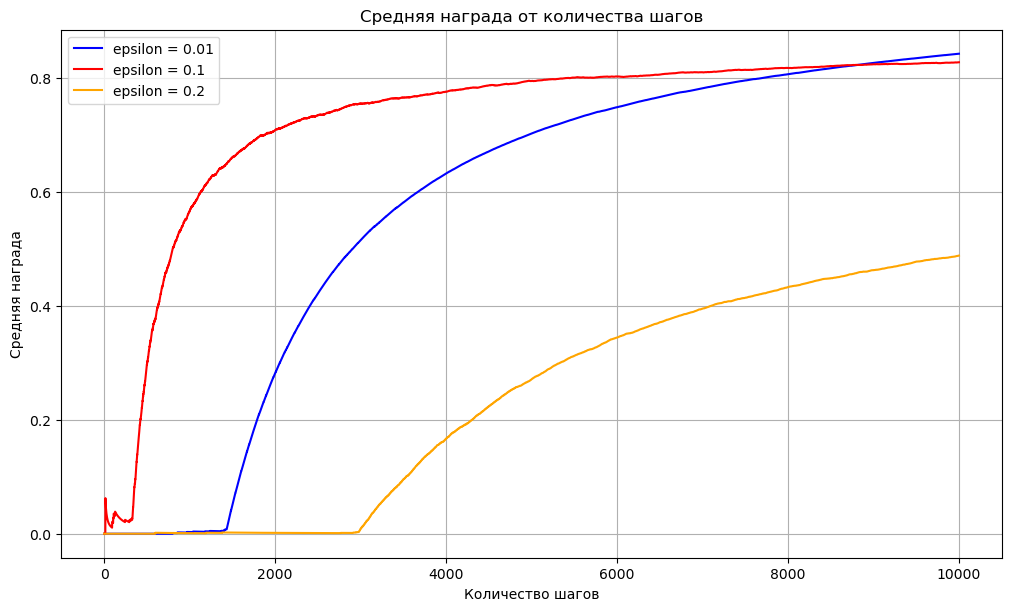

In [357]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, figsize=(10, 6), constrained_layout=True)

max_steps_array = [i for i in range(10, 100)]

win_max_steps_array_001 = play_game(epsilon = 0.01)[2]

win_max_steps_array_01 = play_game(epsilon = 0.1)[2]

win_max_steps_array_02 = play_game(epsilon = 0.2)[2]


axs.set_title('Средняя награда от количества шагов')
axs.set_xlabel('Количество шагов')
axs.set_ylabel('Средняя награда')
axs.plot(win_max_steps_array_001, 'blue', label = 'epsilon = 0.01')
axs.plot(win_max_steps_array_01, 'red', label = 'epsilon = 0.1')
axs.plot(win_max_steps_array_02, 'orange', label = 'epsilon = 0.2')
axs.legend()
axs.grid(True)


Произведем одну игру, чтобы проследить за действиями агента. При этом будем считать модель полностью обученной, то есть действия выбираются жадно, значения ценностей действий в таблице не обновляются.

In [322]:
import time


#Жадный выбор действий
def choose_action_one_game(state):
    action = np.random.choice(np.array(np.argwhere(Q[state, :] == np.amax(Q[state, :])).flatten().tolist()))
    return action


states = []  #Массив для сохранения состояний агента в течение игры
t = 0
state = env.reset()
wn = 0
while (t < 100):
    env.render()
    time.sleep(time_delay)
    clear_output(wait=True)
    action = choose_action_one_game(state)
    state2, reward, done, info = env.step(action)
    states.append(state)
    state = state2
    t += 1
    if done and reward == 1:
        wn = 1
    if done:
        break
if wn == 1:
    print("!!!Победа!!!")

Отобразим маршрут

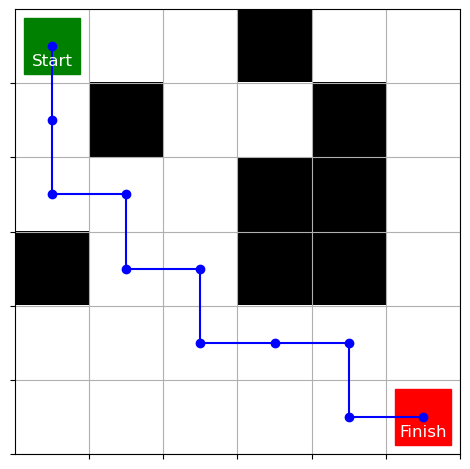

In [324]:
import matplotlib.pyplot as plt

def make_maze_pic(maze):
  maze_pic=[]
  for i in range(len(maze)):
    row = []
    for j in range(len(maze[i])):
      if maze[i][j] == 'S':
        row.append(0)
      if maze[i][j] == 'F':
        row.append(0)
      if maze[i][j] == 'H':
        row.append(1)
      if maze[i][j] == 'G':
        row.append(0)
    maze_pic.append(row)
  maze_pic = np.array(maze_pic)
  return maze_pic


#Make maze fit to plot
maze_pic = make_maze_pic(random_map)
nrows, ncols = maze_pic.shape

#Arrays of picture elements
rw = np.remainder(states,nrows)
cl = np.floor_divide(states,nrows)
if wn == 1:
  rw = np.append(rw, [nrows-1])
  cl = np.append(cl,[ncols-1])

#Picture plotting
fig, ax1 = plt.subplots(1, 1, tight_layout=True)
ax1.clear()
ax1.set_xticks(np.arange(0.5, nrows, step=1))
ax1.set_xticklabels([])
ax1.set_yticks(np.arange(0.5, ncols, step=1))
ax1.set_yticklabels([])
ax1.grid(True)
ax1.plot([0],[0], "gs", markersize=40)  # start is a big green square
ax1.text(0, 0.2,"Start", ha="center", va="center", color="white", fontsize=12) #Start text
ax1.plot([nrows-1],[ncols-1], "rs", markersize=40)  # exit is a big red square
ax1.text(nrows-1, ncols-1+0.2,"Finish", ha="center", va="center", color="white", fontsize=12) #Exit text
ax1.plot(rw,cl, ls = '-', color = 'blue') #Blue lines path
ax1.plot(rw,cl, "bo")  # Blue dots visited cells
ax1.imshow(maze_pic, cmap="binary")

# Задача 3

Используйте вместо алгоритма Q-обучения алгоритм SARSA. Обратите внимание на то, что требуется изменить количество игр. То есть `total_games = 40000`. Запускать блоки следует последвательно с самого начала (из-за `random_seed`). Отдельно обращаем ваше внимание на то, что при изменении алгоритма с Q-обучения на SARSA модификации подлежит как процесс обучения, так и функция `learn()`. Кроме того, у функции `learn()` должен появиться дополнительный аргумент (следующее действие). Ниже приведен фрагмент кода с пояснениями, как именно нужно модифицировать алгоритм.



In [372]:
def learn_sarsa(gamma, lr_rate, state, state2, reward, action, action2, done, Q):
    if done:
        Q[state, action] = Q[state, action] + lr_rate*(reward - Q[state, action])
    else:    
        Q[state, action] = Q[state, action] + lr_rate*(reward+ gamma*Q[state2, action2] - Q[state, action])

In [459]:

from tqdm import tqdm

np.random.seed(random_seed)


def play_game_sarsa(total_games=40000, max_steps=100, epsilon=0.1, gamma=0.8, lr_rate=0.9,
                    choose_action_type='e_greedy', tau=0.5, delta=1.5, value=10):
    '''
    :param value: для оптимистичных начальных оценок
    :param delta: для UCB
    :param tau: для softmax
    :param choose_action_type: Стратегия отбора нужного действия
    :param total_games: Количество игр
    :param max_steps: Максимальное количество шагов в игре
    :param epsilon: Параметр эпсилон при использовании эпсилон жадной стратегии
    :param gamma: Коэффициент дисконтирования гамма
    :param lr_rate: Коэффициент скорости обучения альфа
    :return: Количество выигранных игр, Пять побед подряд впервые было одержано в игре 
    '''
    ucb_dict = {i: 0 for i in range(env.action_space.n)}

    Q = np.zeros((env.observation_space.n, env.action_space.n))

    win_count = 0
    five_win_array = []
    game_with_five_win = 0
    five_flag = False
    rewards_array = []
    #Main cycle
    for game in tqdm(range(total_games)):
        state = env.reset()
        t = 0
        if choose_action_type == 'softmax':
            action = choose_action_softmax(epsilon, state, Q, tau=tau)
        elif choose_action_type == 'ucb':
            action = choose_action_ucb(ucb_dict, epsilon, state, t, Q, delta)
        else:
            action = choose_action(state, epsilon, Q)
        mini_reward = []    
        while t < max_steps:

            t += 1

            state2, reward, done, info = env.step(action)

            if choose_action_type == 'softmax':
                action2 = choose_action_softmax(epsilon, state2, Q, tau=tau)
            elif choose_action_type == 'ucb':
                action2 = choose_action_ucb(ucb_dict, epsilon, state2, t, Q,
                                            delta)
            else:
                action2 = choose_action(state2, epsilon, Q)
                #выбор действия как для следующего шага игры, так и для обновления ценности совершенного действия

            if t == max_steps:
                done = True
            if choose_action_type == 'optimize_values':
                learn_optimize_values(gamma, lr_rate, state, state2, reward, action, done, Q, value)
            else:
                learn_sarsa(gamma, lr_rate, state, state2, reward, action, action2, done,
                            Q)  # action2 также передается в функцию обучения

            state = state2

            action = action2

            if reward == 1 and done:
                win_count += 1
                five_win_array.append(1)
                if sum(five_win_array) == 5 and len(five_win_array) == 5 and five_flag is False:
                    game_with_five_win = game + 1
                    five_flag = True
            elif reward == 0 and done:
                five_win_array = []

            if done:
                rewards_array.append(reward)
                break
    return win_count, game_with_five_win, np.cumsum(rewards_array) / (np.arange(total_games) + 1)

In [454]:
win_count, game_with_five_win, mean_rewards = play_game_sarsa()

print("Количество побед в серии из 40 000 игр: ", win_count)
print("Пять побед подряд впервые было одержано в игре ", game_with_five_win)

100%|██████████| 40000/40000 [00:06<00:00, 5924.00it/s]

Количество побед в серии из 40 000 игр:  32328
Пять побед подряд впервые было одержано в игре  894


. В результате обучения должны получиться следующие ответы:



*   Количество побед в серии из 40 000 игр:  32328
*   Пять побед подряд впервые было одержано в игре  894

Реализуем также и другие способы выбора стратегии

In [452]:
# softmax
def choose_action_softmax(epsilon, state, Q, tau=0.5):
    action = 0
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, env.action_space.n)  #***
    else:
        zn = sum(np.exp(Q[state, :] / tau))
        T = range(len(Q[state, :]))
        action = np.random.choice(T, p=[np.exp(Q[state, :][x] / tau) / zn for x in T])
    return action


# UCB

def choose_action_ucb(ucb_dict, epsilon, state, t, Q, delta=1.5):
    action = 0
    T = Q[state, :].copy()
    if np.random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, env.action_space.n)  #***
    else:
        ucb_array = [(T[i] + delta * (np.log(t+1) / ucb_dict[i]) ** 0.5) if T[i] != 0 else T[i] for i in range(len(T))]
        action = np.random.choice(list(np.argwhere(ucb_array == np.amax(ucb_array)).flatten().tolist()))
        ucb_dict[action] += 1
    return action


# Оптимистичные начальные оценки
def learn_optimize_values(gamma, lr_rate, state, state2, reward, action, done, Q, value=10):
    if done:
        Q[state, action] = Q[state, action] + lr_rate * (reward - Q[state, action])
    elif Q[state, action] == 0:
        Q[state, action] = value + lr_rate * (reward + gamma * np.max(Q[state2, :]) - Q[state, action])
    else:
        Q[state, action] = Q[state, action] + lr_rate * (reward + gamma * np.max(Q[state2, :]) - Q[state, action])

Построим графики среднего выигрыша от количества шагов при разных стратегиях выбора

100%|██████████| 20000/20000 [00:03<00:00, 6139.34it/s]


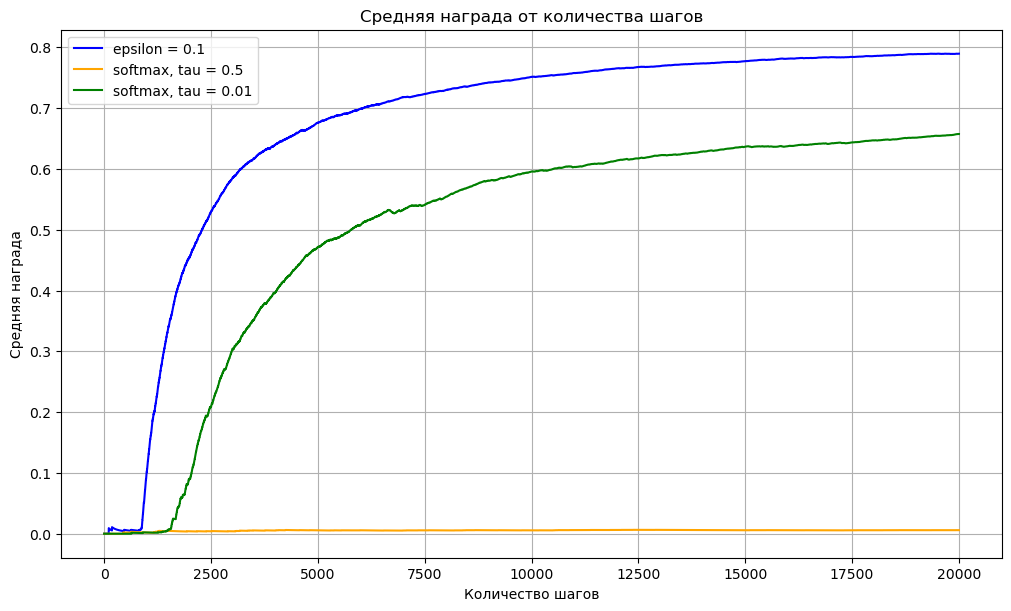

In [460]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, figsize=(10, 6), constrained_layout=True)


win_max_steps_array_001 = play_game_sarsa(total_games=20000, epsilon = 0.1)[2]

win_max_steps_array_01 = play_game_sarsa(total_games=20000, choose_action_type='softmax', tau = 0.5)[2]

win_max_steps_array_02 = play_game_sarsa(total_games=20000, choose_action_type='softmax', tau = 0.01)[2]


axs.set_title('Средняя награда от количества шагов')
axs.set_xlabel('Количество шагов')
axs.set_ylabel('Средняя награда')
axs.plot(win_max_steps_array_001, 'blue', label = 'epsilon = 0.1')
axs.plot(win_max_steps_array_01, 'orange', label = 'softmax, tau = 0.5')
axs.plot(win_max_steps_array_02, 'green', label = 'softmax, tau = 0.01')
axs.legend()
axs.grid(True)


100%|██████████| 40000/40000 [00:10<00:00, 3669.33it/s]


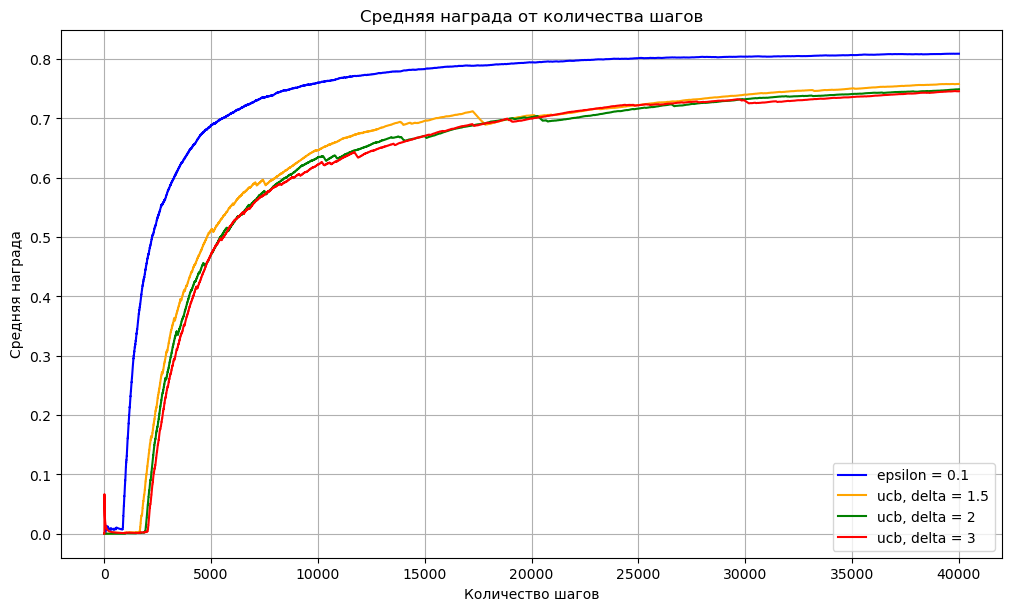

In [461]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, figsize=(10, 6), constrained_layout=True)

win_max_steps_array_001 = play_game_sarsa(total_games=40000, epsilon=0.1)[2]

win_max_steps_array_01 = play_game_sarsa(total_games=40000, epsilon=0.1, choose_action_type='ucb', delta=1.5)[2]

win_max_steps_array_02 = play_game_sarsa(total_games=40000, epsilon=0.1, choose_action_type='ucb', delta=2)[2]

win_max_steps_array_03 = play_game_sarsa(total_games=40000, epsilon=0.1, choose_action_type='ucb', delta=3)[2]

axs.set_title('Средняя награда от количества шагов')
axs.set_xlabel('Количество шагов')
axs.set_ylabel('Средняя награда')
axs.plot(win_max_steps_array_001, 'blue', label='epsilon = 0.1')
axs.plot(win_max_steps_array_01, 'orange', label='ucb, delta = 1.5')
axs.plot(win_max_steps_array_02, 'green', label='ucb, delta = 2')
axs.plot(win_max_steps_array_03, 'red', label='ucb, delta = 3')
axs.legend()
axs.grid(True)


100%|██████████| 40000/40000 [00:11<00:00, 3402.29it/s]


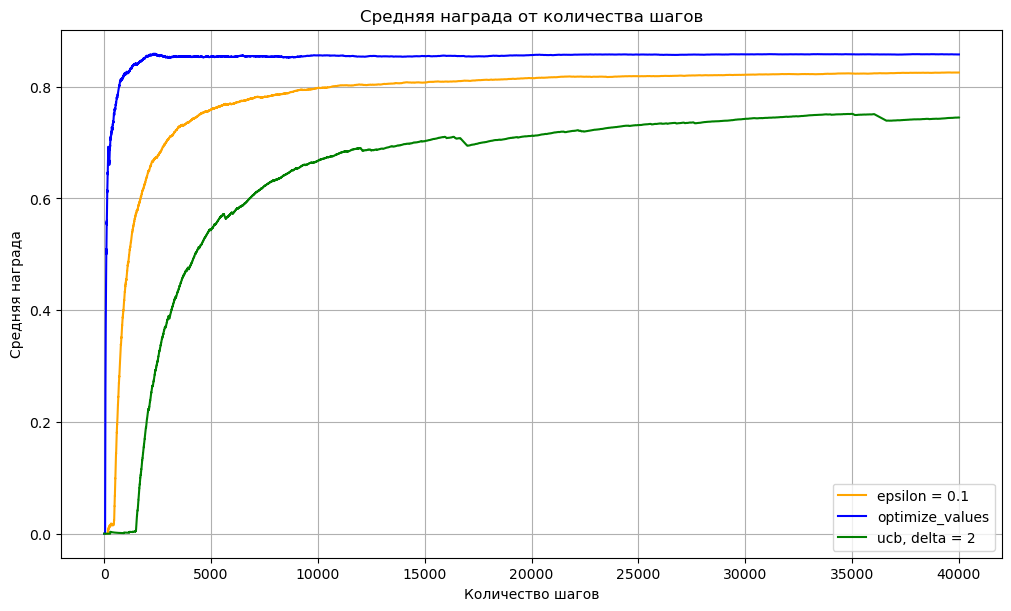

In [462]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, figsize=(10, 6), constrained_layout=True)


win_max_steps_array_001 = play_game_sarsa(total_games=40000, epsilon = 0.1)[2]

win_max_steps_array_01 = play_game_sarsa(total_games=40000, choose_action_type='optimize_values')[2]

win_max_steps_array_02 = play_game_sarsa(total_games=40000, choose_action_type='ucb', delta = 2)[2]




axs.set_title('Средняя награда от количества шагов')
axs.set_xlabel('Количество шагов')
axs.set_ylabel('Средняя награда')
axs.plot(win_max_steps_array_001, 'orange', label = 'epsilon = 0.1')
axs.plot(win_max_steps_array_01, 'blue', label = 'optimize_values')
axs.plot(win_max_steps_array_02, 'green', label = 'ucb, delta = 2')
axs.legend()
axs.grid(True)
